In [1]:
!which python

/Users/clarehuang/miniconda3/envs/falwa_env/bin/python


In [2]:
import falwa

In [3]:
import xarray as xr

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [5]:
# Load MERRA2 dataset
uvt_data = xr.open_mfdataset("data/MERRA2/[UVT].1980.daily.nc")
dtdtlwr_data = xr.open_mfdataset("data/MERRA2/DTDTLWR.1980.daily.nc")

In [15]:
dtdtlwr_data

<xarray.Dataset>
Dimensions:  (time: 7, lon: 360, lat: 181, level: 37)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 1980-01-07T12:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * level    (level) float64 1e+03 975.0 950.0 925.0 900.0 ... 4.0 3.0 2.0 1.0
Data variables:
    DTDTLWR  (time, level, lat, lon) float32 dask.array<chunksize=(7, 37, 181, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Jan 02 14:12:54 2025: cdo seldate,1980-01-01,1980-01-07...
    CDO:          Climate Data Operators version 2.0.3 (https://mpimet.mpg.de...

In [6]:
uvt_data['lon']

<xarray.DataArray 'lon' (lon: 360)>
array([  0.,   1.,   2., ..., 357., 358., 359.])
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [7]:
uvt_data['level']

<xarray.DataArray 'level' (level: 37)>
array([1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,  775.,
        750.,  725.,  700.,  650.,  600.,  550.,  500.,  450.,  400.,  350.,
        300.,  250.,  200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,
         10.,    7.,    5.,    4.,    3.,    2.,    1.])
Coordinates:
  * level    (level) float64 1e+03 975.0 950.0 925.0 900.0 ... 4.0 3.0 2.0 1.0
Attributes:
    standard_name:  air_pressure
    long_name:      vertical level
    units:          hPa
    positive:       down
    axis:           Z
    vmin:           -1000000000000000.0
    vmax:           1000000000000000.0
    coordinate:     pressure

In [8]:
# Prepare coordinates

xlon = uvt_data['lon'].values
# latitude has to be in ascending order
ylat = uvt_data['lat'].values
# pressure level has to be in descending order (ascending height)
plev = uvt_data['level'].values

nlon = xlon.size
nlat = ylat.size
nlev = plev.size
print(f"nlon: {nlon}, nlat: {nlat}, nlev:{nlev}")


nlon: 360, nlat: 181, nlev:37


In [9]:
# Get once slice of data to test
tstep = 0
uu = uvt_data['U'].values[tstep, :, :, :]
vv = uvt_data['V'].values[tstep, :, :, :]
tt = uvt_data['T'].values[tstep, :, :, :]

Do scipy interpolation
 nlon, nlat, kmax, jd
         360         181          49          91


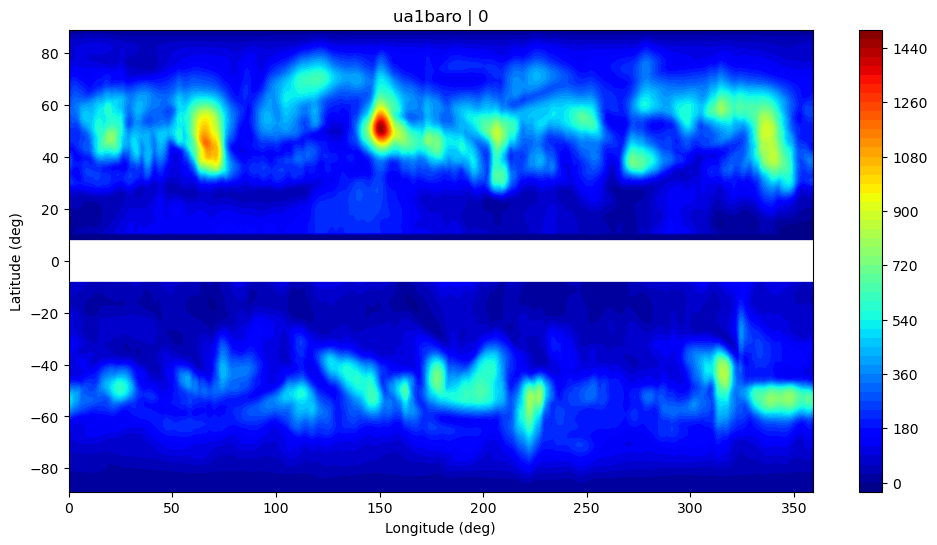

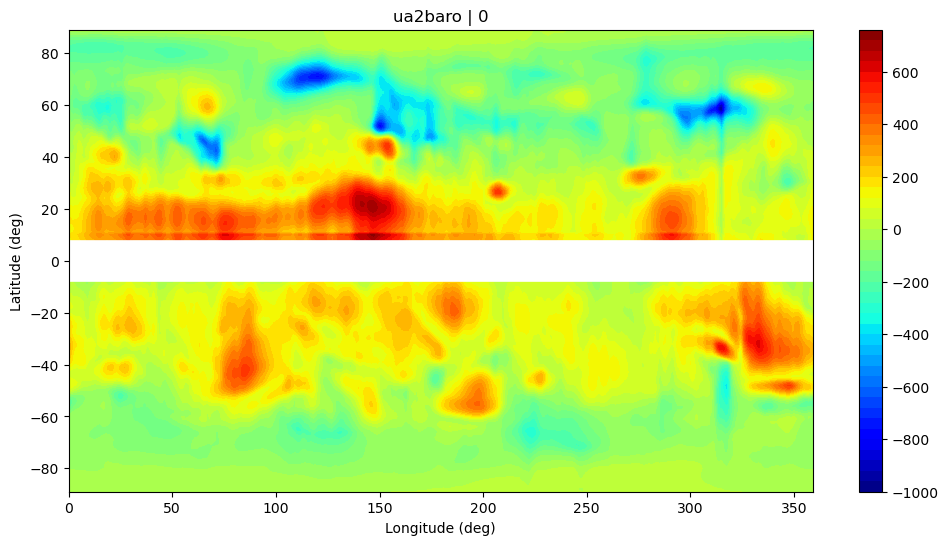

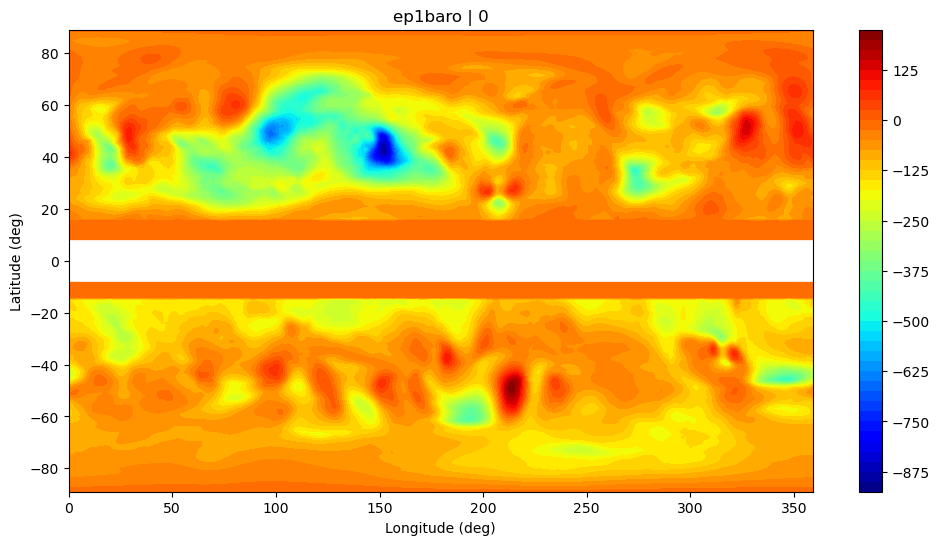

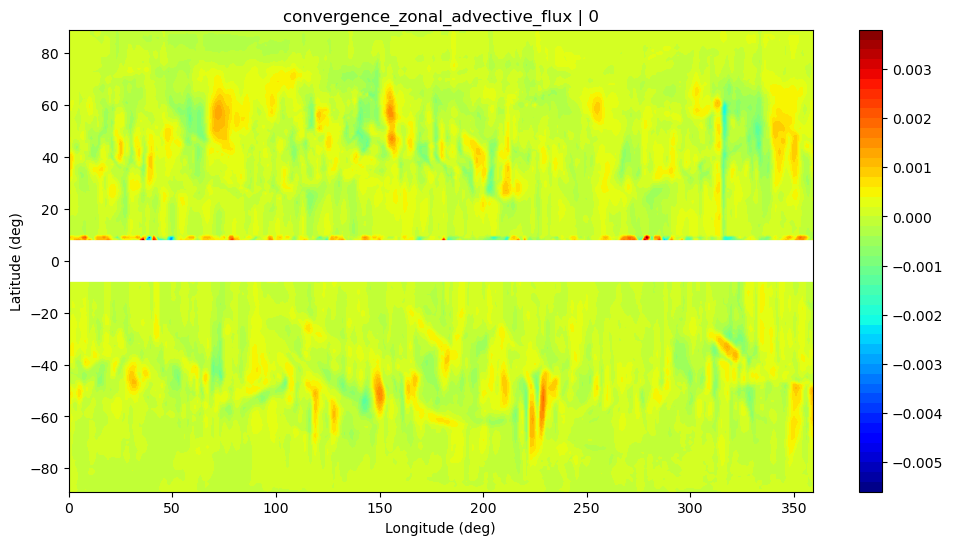

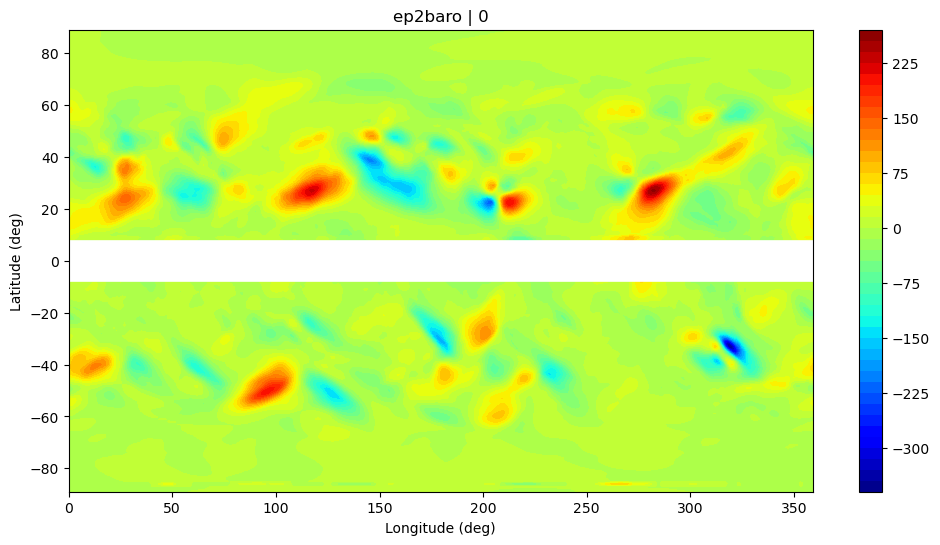

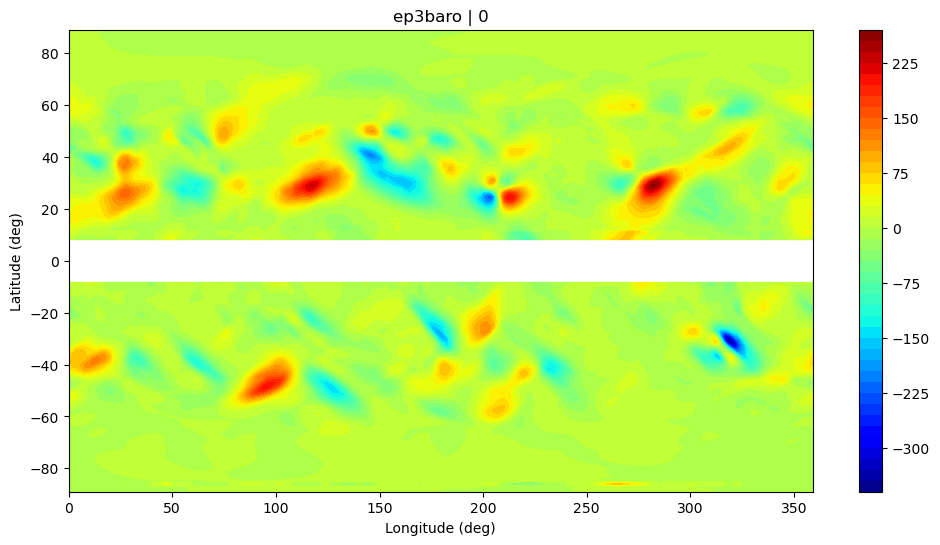

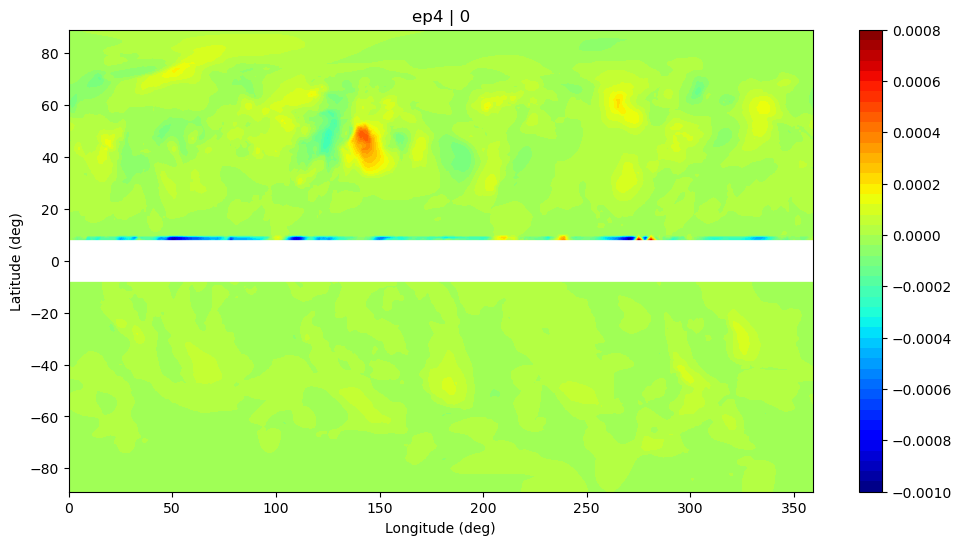

In [10]:
from falwa.oopinterface import QGFieldNHN22

qgfield_nhn22 = QGFieldNHN22(xlon, ylat, plev, uu, vv, tt, northern_hemisphere_results_only=False, eq_boundary_index=5)

qgfield_nhn22.interpolate_fields(return_named_tuple=False)

qgfield_nhn22.compute_reference_states(return_named_tuple=False)

ncforce = np.zeros((qgfield_nhn22.kmax, qgfield_nhn22.nlat, qgfield_nhn22.nlon))
qgfield_nhn22.compute_lwa_and_barotropic_fluxes(return_named_tuple=False, ncforce=ncforce)

list_of_flux_var = [
    (qgfield_nhn22._barotropic_flux_terms_storage.ua1baro, "ua1baro"),
    (qgfield_nhn22._barotropic_flux_terms_storage.ua2baro, "ua2baro"), 
    (qgfield_nhn22._barotropic_flux_terms_storage.ep1baro, "ep1baro"),
    (qgfield_nhn22.convergence_zonal_advective_flux.T, "convergence_zonal_advective_flux"),
    (qgfield_nhn22._barotropic_flux_terms_storage.ep2baro, "ep2baro"), 
    (qgfield_nhn22._barotropic_flux_terms_storage.ep3baro, "ep3baro"), 
    (qgfield_nhn22._barotropic_flux_terms_storage.ep4, "ep4")]

for variable, varname in list_of_flux_var:

    if varname == "ep1baro":
        variable[:, qgfield_nhn22.equator_idx-15:qgfield_nhn22.equator_idx+15] = 0
    
    plt.figure(figsize=(12,6))
    plt.contourf(xlon, ylat[1:-1], variable[:, 1:-1].T, 50, cmap='jet')
    plt.axhline(y=0, c='w', lw=30)
    plt.ylabel('Latitude (deg)')
    plt.xlabel('Longitude (deg)')
    plt.colorbar()
    plt.title(varname + ' | ' + str(0))
    plt.show()


## Compute ncforce term for input

In [17]:
from falwa.utilities import z_derivative_of_prod

# Interpolate DTDTLWR onto regular z-grid first
interpolated_dtdtlwr = qgfield_nhn22._vertical_interpolation(dtdtlwr_data['DTDTLWR'].values[0, :, :, :], kind="linear", axis=0)

ncforce_input = z_derivative_of_prod(
    stat_n=qgfield_nhn22._domain_average_storage.static_stability_n,
    stat_s=qgfield_nhn22._domain_average_storage.static_stability_s,
    kmax=qgfield_nhn22.kmax,
    equator_idx=qgfield_nhn22.equator_idx,
    dz=qgfield_nhn22.dz,
    density_decay=np.exp(-qgfield_nhn22.height/qgfield_nhn22.scale_height),
    gfunc=interpolated_dtdtlwr,
    multiplier=2 * qgfield_nhn22.omega * np.sin(np.deg2rad(qgfield_nhn22.ylat[np.newaxis, :])) * np.exp(qgfield_nhn22.height[:, np.newaxis]/qgfield_nhn22.scale_height))

## Check private variables dimension

In [11]:
qgfield_nhn22._interpolated_field_storage.interpolated_v.shape

(360, 181, 49)

In [12]:
v_e_theta_e = qgfield_nhn22._interpolated_field_storage.interpolated_v[:, :, :] *\
    (qgfield_nhn22._interpolated_field_storage.interpolated_theta[:, :, :] - qgfield_nhn22._reference_states_storage.ptref[np.newaxis, :, :])

In [13]:
new = qgfield_nhn22._interpolated_field_storage.fortran_to_python(v_e_theta_e)
new.shape

(49, 181, 360)

Do scipy interpolation
   276690071           0           4  converged at n =         1658
   276690071           0           4  converged at n =         1119


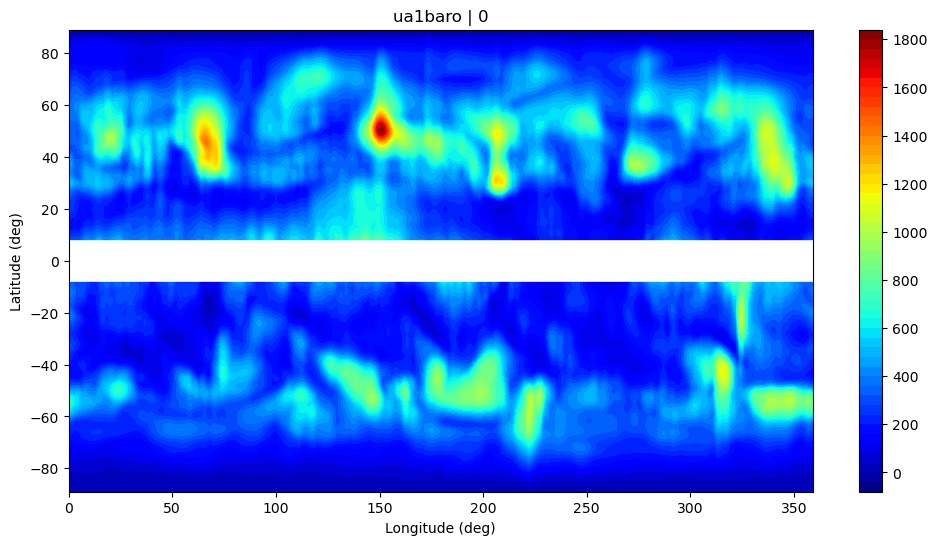

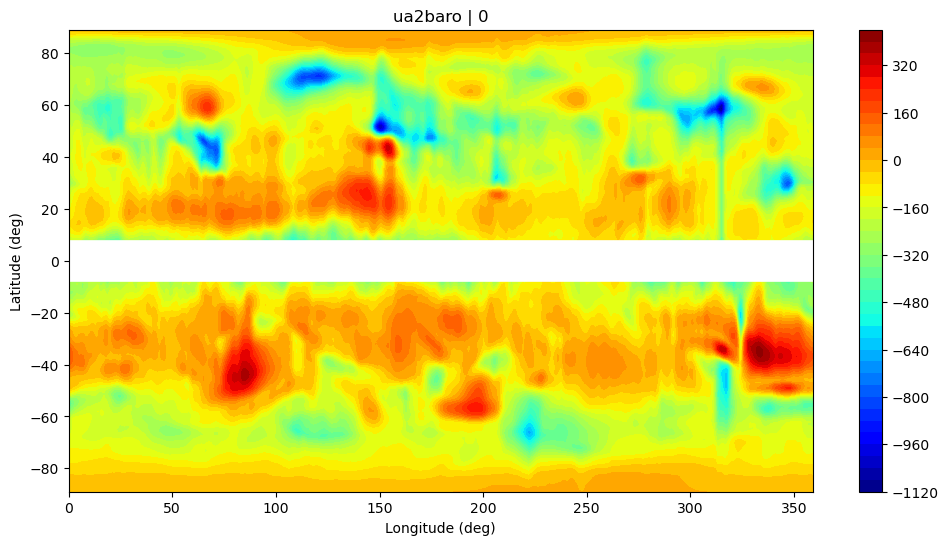

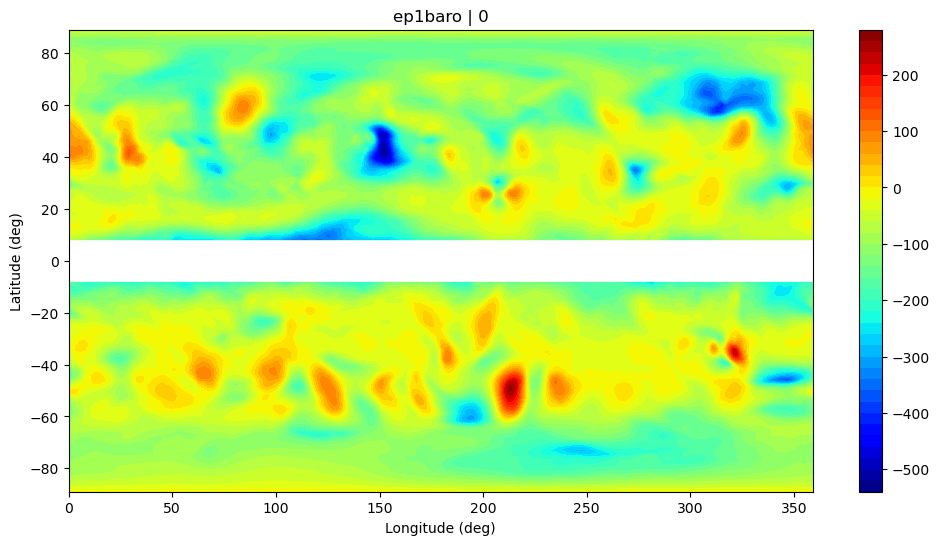

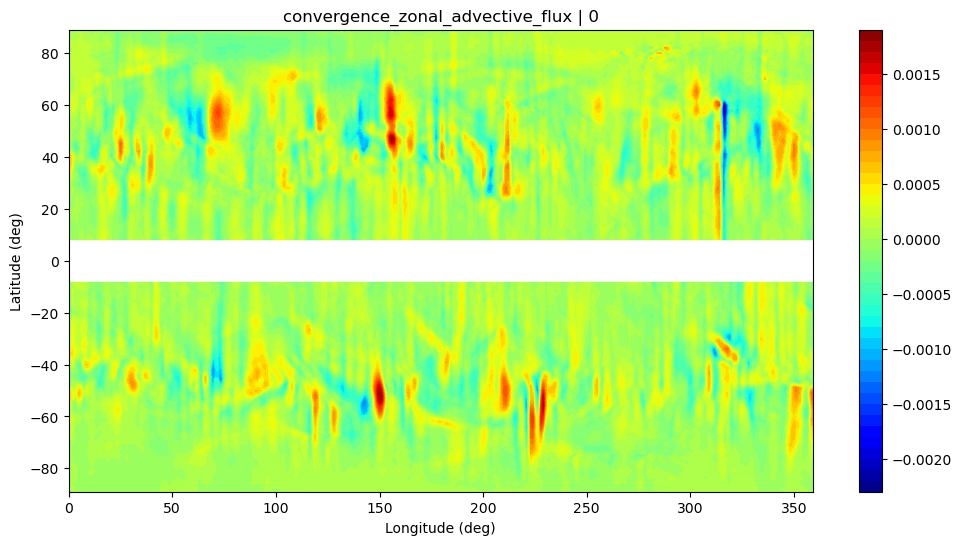

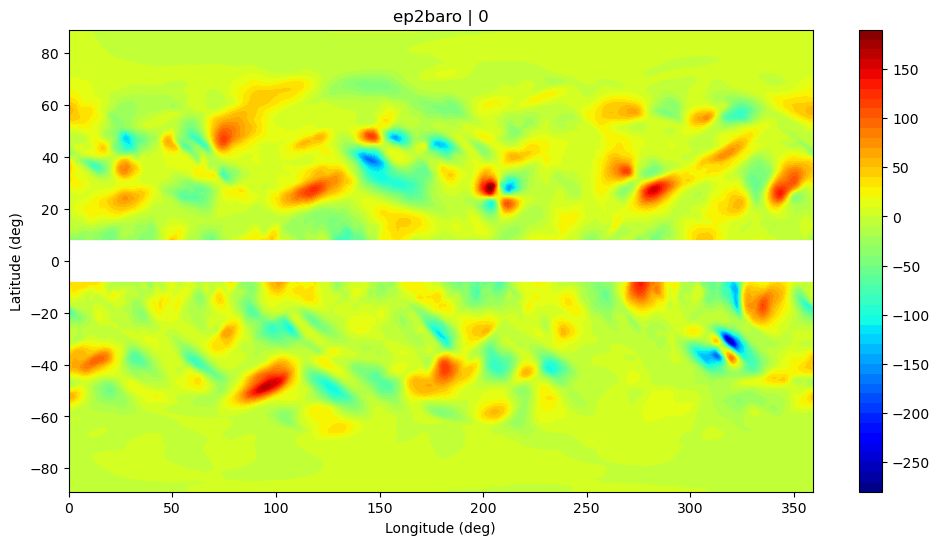

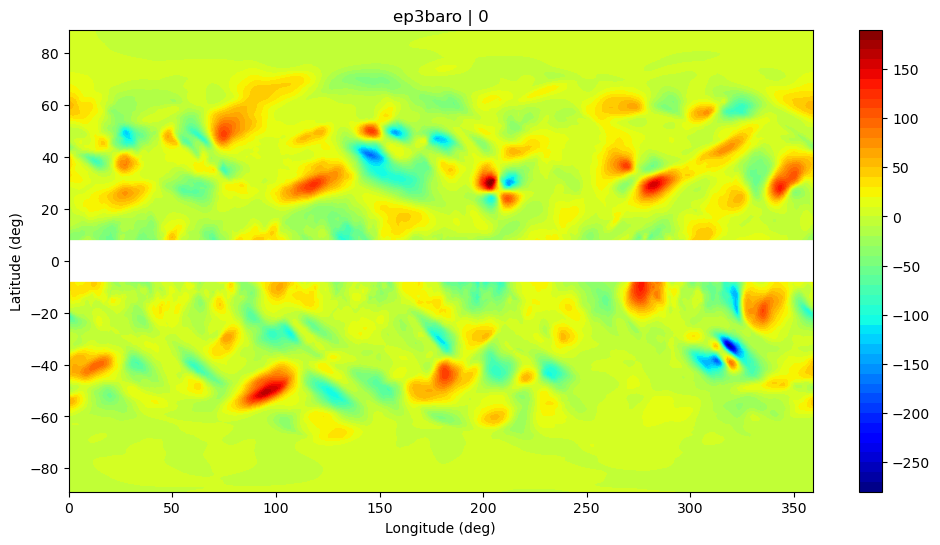

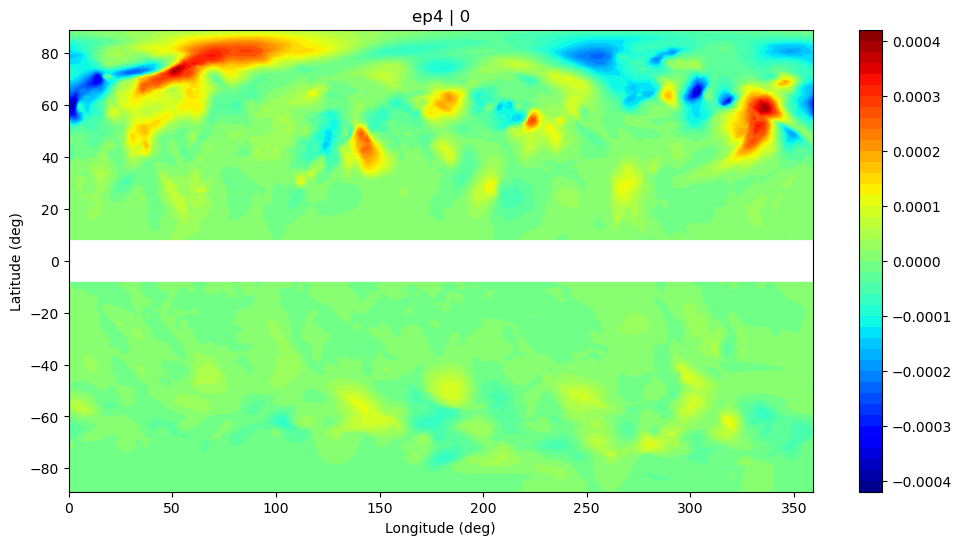

In [14]:
from falwa.oopinterface import QGFieldNH18
# Cross check with NH18

qgfield_nh18 = QGFieldNH18(xlon, ylat, plev, uu, vv, tt, northern_hemisphere_results_only=False)

qgfield_nh18.interpolate_fields(return_named_tuple=False)

qgfield_nh18.compute_reference_states(return_named_tuple=False)

ncforce = np.zeros((qgfield_nh18.kmax, qgfield_nh18.nlat, qgfield_nh18.nlon))
qgfield_nh18.compute_lwa_and_barotropic_fluxes(return_named_tuple=False, ncforce=ncforce)

list_of_flux_var = [
    (qgfield_nh18._barotropic_flux_terms_storage.ua1baro, "ua1baro"),
    (qgfield_nh18._barotropic_flux_terms_storage.ua2baro, "ua2baro"), 
    (qgfield_nh18._barotropic_flux_terms_storage.ep1baro, "ep1baro"),
    (qgfield_nh18.convergence_zonal_advective_flux.T, "convergence_zonal_advective_flux"),
    (qgfield_nh18._barotropic_flux_terms_storage.ep2baro, "ep2baro"), 
    (qgfield_nh18._barotropic_flux_terms_storage.ep3baro, "ep3baro"), 
    (qgfield_nh18._barotropic_flux_terms_storage.ep4, "ep4")]

for variable, varname in list_of_flux_var:

    #if varname == "ep1baro":
    #    variable[:, qgfield_nh18.equator_idx-15:qgfield_nh18.equator_idx+15] = 0
    
    plt.figure(figsize=(12,6))
    plt.contourf(xlon, ylat[1:-1], variable[:, 1:-1].T, 50, cmap='jet')
    plt.axhline(y=0, c='w', lw=30)
    plt.ylabel('Latitude (deg)')
    plt.xlabel('Longitude (deg)')
    plt.colorbar()
    plt.title(varname + ' | ' + str(0))
    plt.show()
